# Train Autoencoder with Stereozoom

In [ ]:
!pip install patchify
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Steps
1. load the stereozoom data as 512 * 512 * 3
2. Load the autoencoder and keep the input size 512 * 512 * 3
3. train the encoder with all images, save model
4. load oct images as whole size
5. patch them as 512 * 512 * 3 matrix
6. build the unet with same layers and shape as autoencoder
7. The U-net should have softmax as output and n_classes = 4
8. replace unet weights with autoencoder.

In [ ]:
#Import whole libraries
import os
import cv2
import glob
import random
import skimage
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm

#From import specific sub-libs or functions/classes
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from patchify import patchify, unpatchify
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Activation, MaxPool2D, Concatenate, Input, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import normalize, img_to_array, to_categorical
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [ ]:
im_height = 512
im_width = 512

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# For Stereozoom
imagepath = r"/content/drive/MyDrive/Image_dataset/image"
maskpath = r"/content/drive/MyDrive/Image_dataset/BINARY_MASK"
# For OCT
images_path = r"/content/drive/MyDrive/OCT_sd/Images"
masks_path = r"/content/drive/MyDrive/OCT_sd/Mask"

In [ ]:
images = os.listdir(imagepath)
masks = os.listdir(maskpath)
# images = os.listdir(imagepath)[:10]
# masks = os.listdir(maskpath)[:10]

In [ ]:
IMAGES = np.zeros((len(masks), im_height, im_width, 3), dtype=np.float32) #create an empty array for all the examples (instance,hight,width,three channels)
MASKS = np.zeros((len(masks), im_height, im_width, 1), dtype=np.float32) #create an empty array for all the examples (instance,hight,width,one channels)

## Load images and masks, resize for training, normalize and convert to floats
for n,image in enumerate(masks): #loop over the mask names and number

    print(n,image)
    mask =  cv2.imread("{}/{}".format(maskpath,image),0)  #read the masks with exact values
    mask =  cv2.resize(mask,(im_height,im_width))   #resize to expand the dimention of the masks

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] >= 0.05:
                mask[i,j] = 1
            else:
                mask[i,j] = 0
    mask = np.expand_dims(mask,axis=2)

    img =  cv2.imread("{}/{}".format(imagepath,image),1) #read the colored image
    img =  cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   #convert to RGB
    img =  cv2.resize(img,(im_height,im_width))   #resize the image for consistancy (there are some images with diff. dimentions)

    IMAGES[n,:,:] = img/255.0   #normalize and convert to floats
    MASKS[n,:,:] = mask/1.0     #normalize and convert to floats

0 70.png
1 71.png
2 72.png
3 73.png
4 74.png
5 75.png
6 76.png
7 77.png
8 78.png
9 79.png


In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x

In [ ]:
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1,p1 = encoder_block(inputs,64)
    s2,p2 = encoder_block(p1,128)
    s3,p3 = encoder_block(p2,256)
    s4,p4 = encoder_block(p3,512)

    b1 = conv_block(p4,1024)

    d1 = decoder_block_for_unet(b1,s4,512)
    d2 = decoder_block_for_unet(d1,s3,256)
    d3 = decoder_block_for_unet(d2,s2,128)
    d4 = decoder_block_for_unet(d3,s1,64)

    outputs = Conv2D(1,1,padding="same",activation ="softmax")(d4)

    model = Model(inputs,outputs,name = "U_net")
    print(model.summary())
    return model

In [ ]:
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    encoded = conv_block(p4, 1024) #Bridge

    return encoded

In [ ]:
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)

    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

In [ ]:
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)

In [ ]:
IMAGES[0].shape

(512, 512, 3)

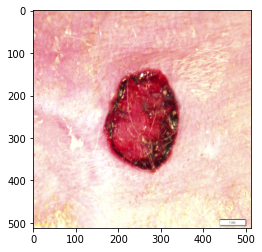

In [ ]:
plt.imshow(IMAGES[0])

In [ ]:
model=build_autoencoder(IMAGES[0].shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512, 512, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 512, 512, 64)     256       
 hNormalization)                                             

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(IMAGES, MASKS,test_size= 0.20, random_state=2022)

In [ ]:
# IMAGES = IMAGES[0:10]
# MASKS = MASKS[0:10]

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy')
model.fit(IMAGES, IMAGES,
        epochs=1,
        batch_size = 1,
        verbose=1)
        # callbacks =[callback])

10/10 [==============================] - 202s 19s/step - loss: 0.0483 - accuracy: 0.7976


1/1 [==============================] - 6s 6s/step


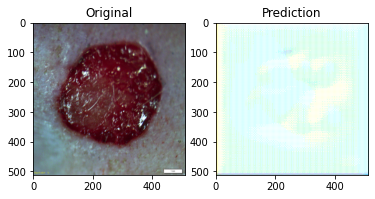

In [ ]:
id = np.random.randint(0,len(IMAGES))
img = np.expand_dims(IMAGES[id,:,:,:],axis=0)
pred = model.predict(img).squeeze()
plt.subplot(1,2,1)
plt.imshow(img.squeeze())
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction')
plt.show()

In [ ]:
# model.save(r"/content/drive/MyDrive/Model/Stereozoom_autoencoder/Wound-seg-data[031122]")

In [ ]:
# my_model = model
# outputs = [layer.output for layer in my_model.layers[1:]]
# model_for_visualization = Model(inputs = my_model.input, outputs = outputs)

In [ ]:
# input_img = img
# feature_maps = model_for_visualization.predict(input_img)

In [ ]:
# layer_num = 32 #Depth of layer...
# square = 8
# ix = 1
# for _ in range(square):
# 	for _ in range(square):
# 		# specify subplot and turn of axis
# 		ax = plt.subplot(square, square, ix)
# 		ax.set_xticks([])
# 		ax.set_yticks([])
# 		# plot filter channel in grayscale
# 		plt.imshow(feature_maps[layer_num][0, :, :, ix-1])
# 		ix += 1
# # show the figure
# plt.show()

# OCT Option 1



In [ ]:
# model1 = load_model(r"/content/drive/MyDrive/Model/Stereozoom_autoencoder/Wound-seg-data[021122]")

In [ ]:
train_images = []

for img_path in sorted(glob.glob(os.path.join(images_path, "*.BMP"))):
    img =  cv2.imread(img_path, 1)
    img =  cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   #convert to RGB
    img =  img[:,:1704,:]   #resize the image for consistancy (there are some images with diff. dimentions)
    img =  patchify(img,(512,512,3),step = 512)
    img =  np.squeeze(img,axis=(0,2))
    train_images.append(img)
train_images = np.concatenate(train_images)
# train_images = normalize(train_images, axis=1)
train_images.shape

(228, 512, 512, 3)

In [ ]:
train_masks = []
for mask_path in sorted(glob.glob(os.path.join(masks_path, "*.png"))):
    mask = cv2.imread(mask_path,cv2.IMREAD_UNCHANGED)
    mask = mask[:,:1704]
    mask = patchify(mask,(512,512),step = 512)
    mask = np.squeeze(mask,axis=(0))
    mask = np.expand_dims(mask,axis=3)
    train_masks.append(mask)

train_masks = np.concatenate(train_masks)
train_masks.shape

(228, 512, 512, 1)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


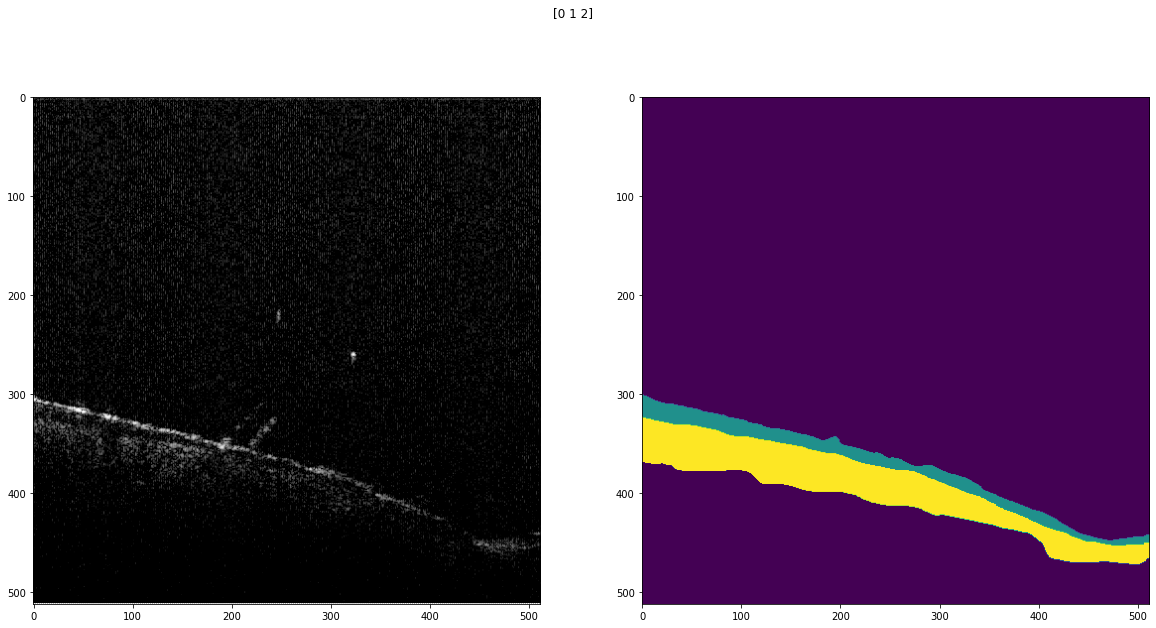

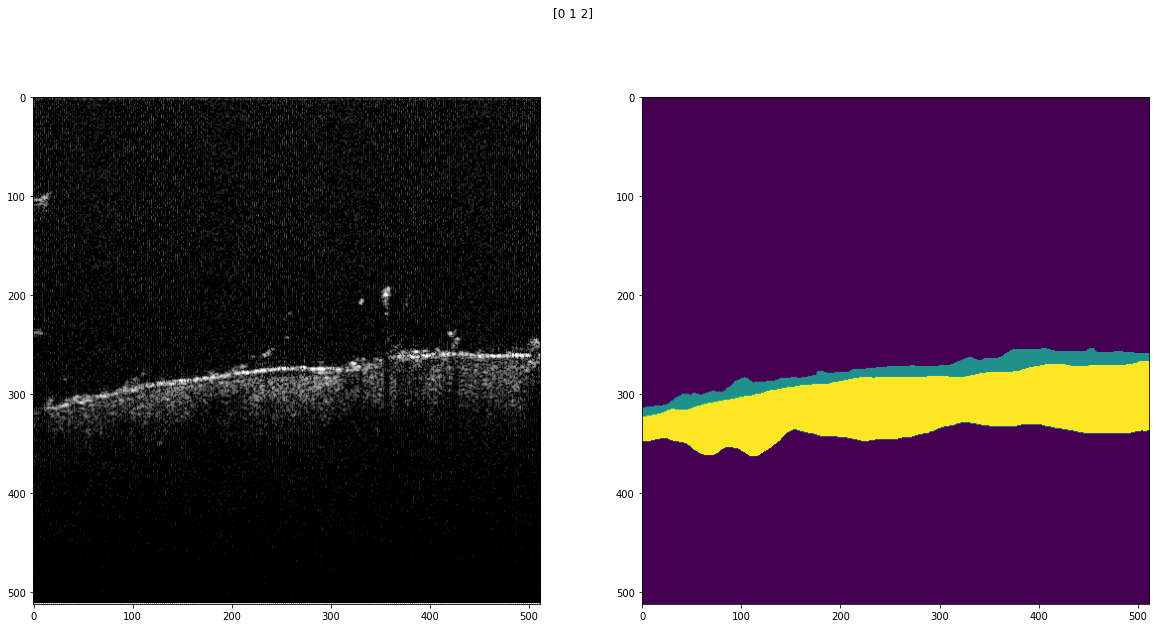

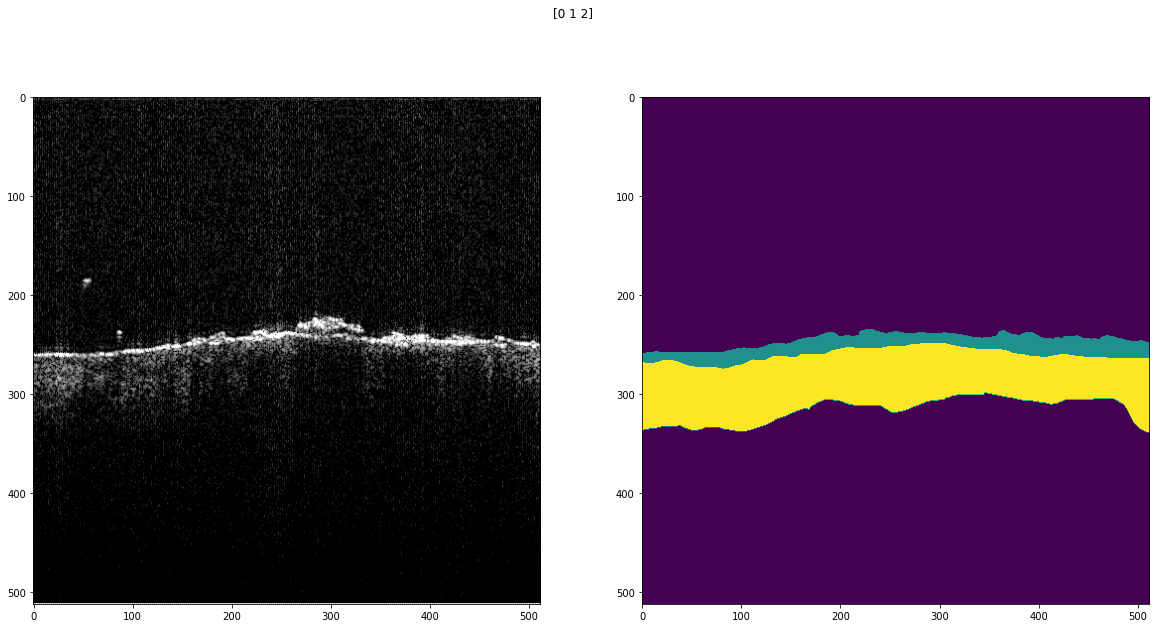

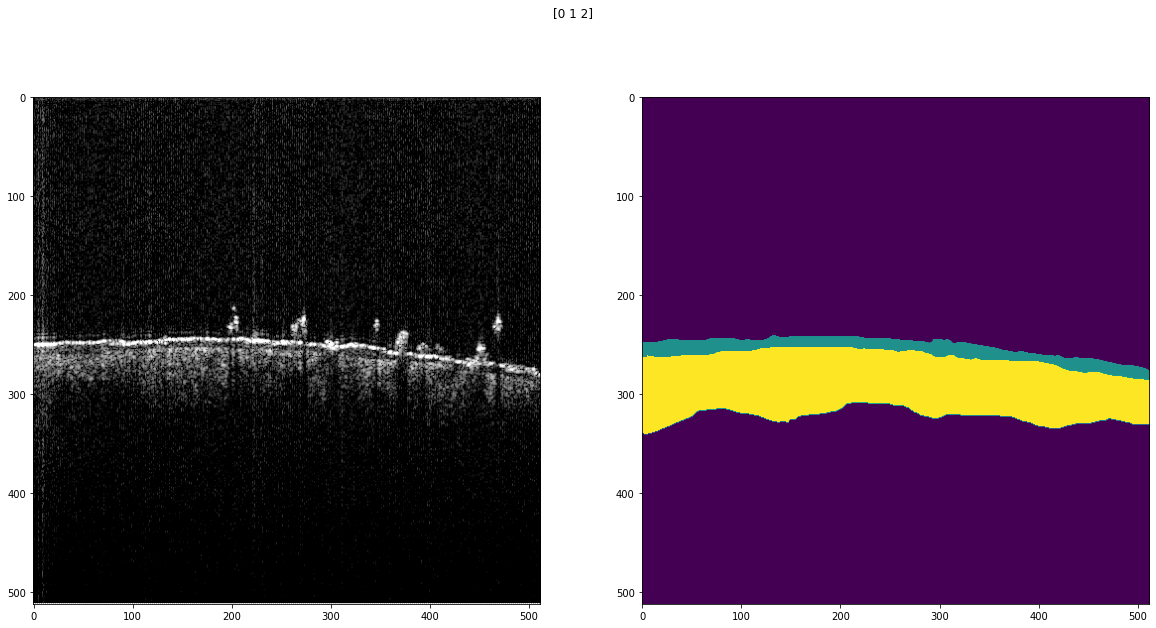

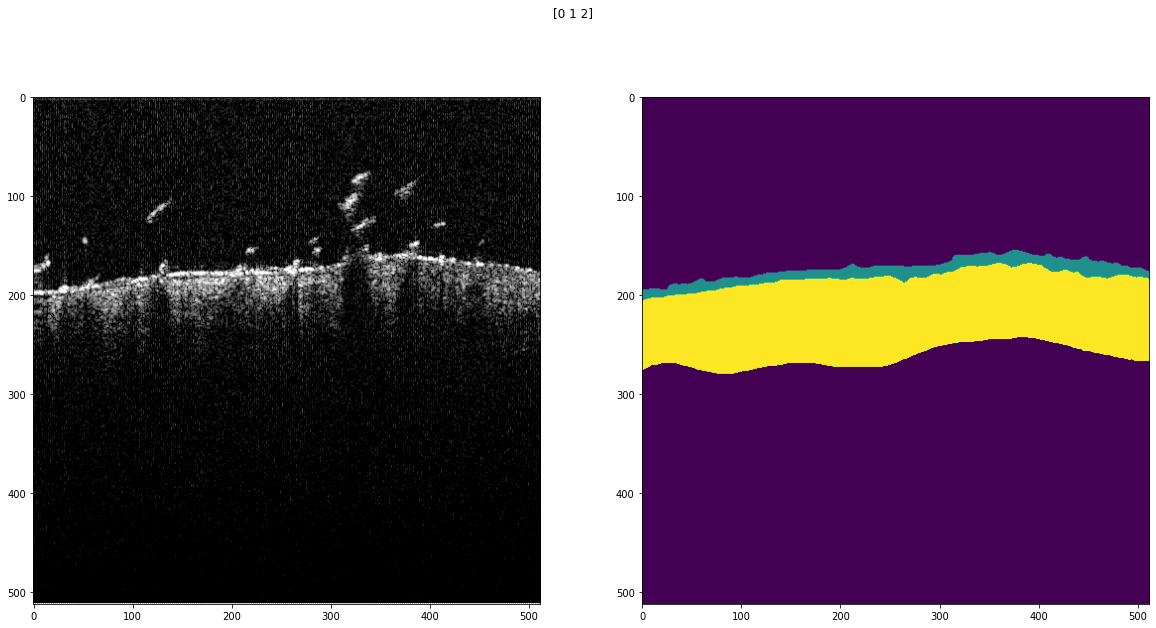

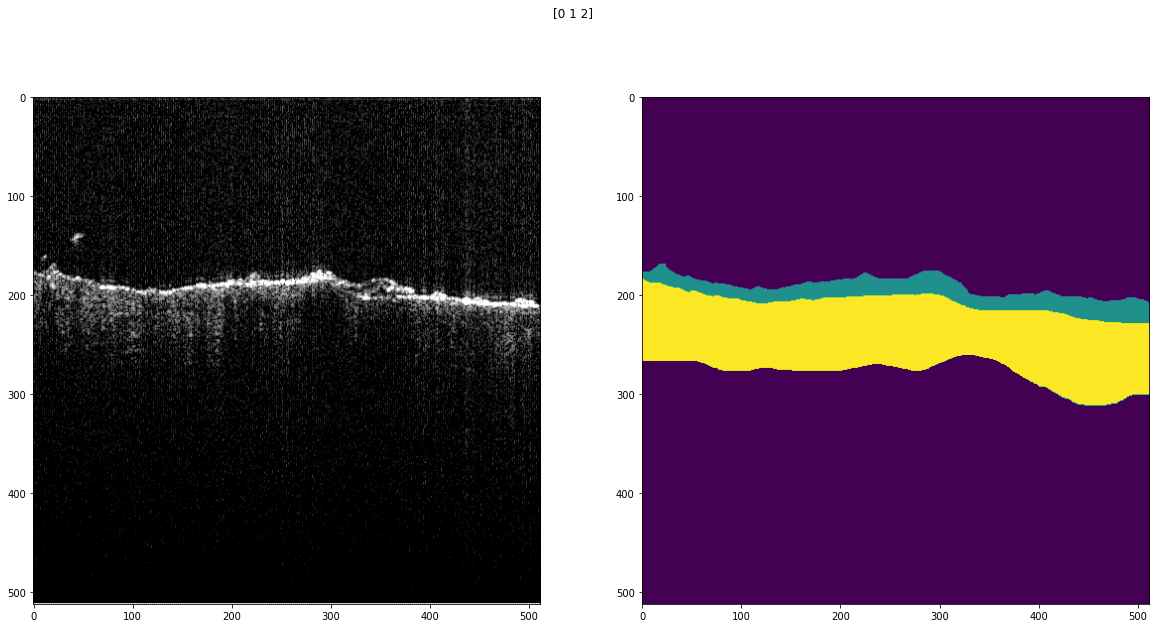

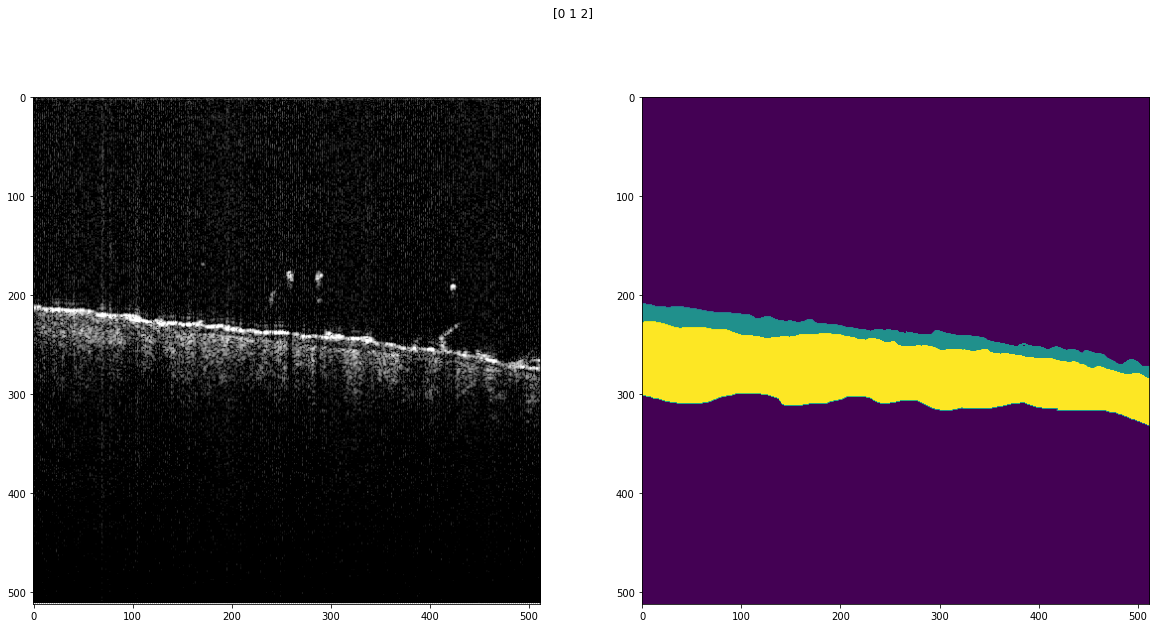

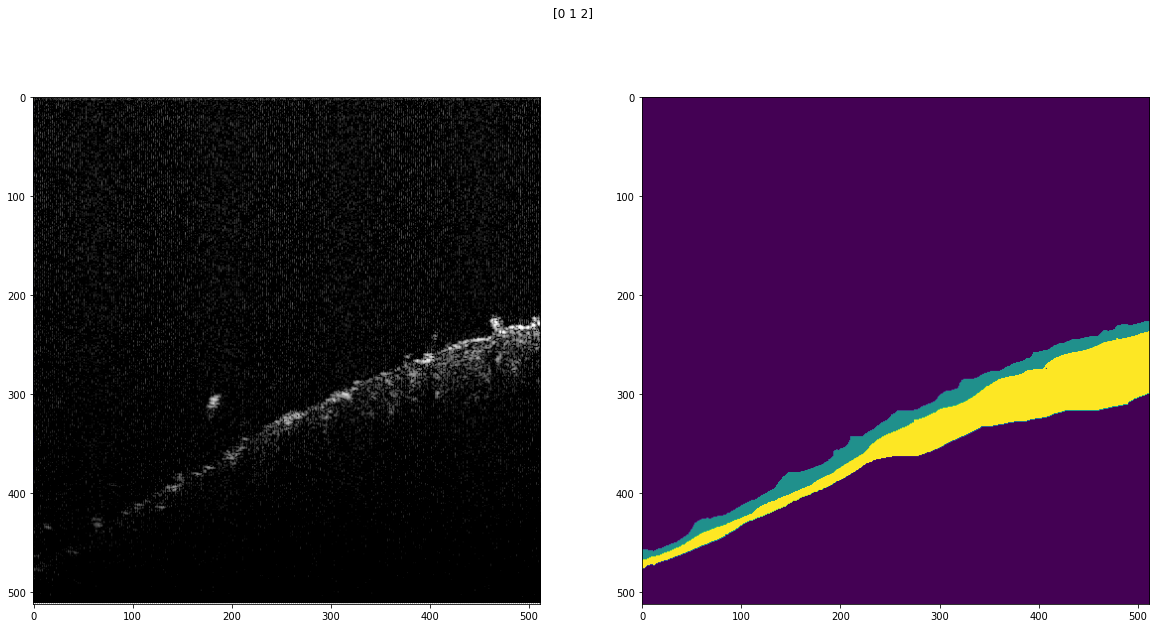

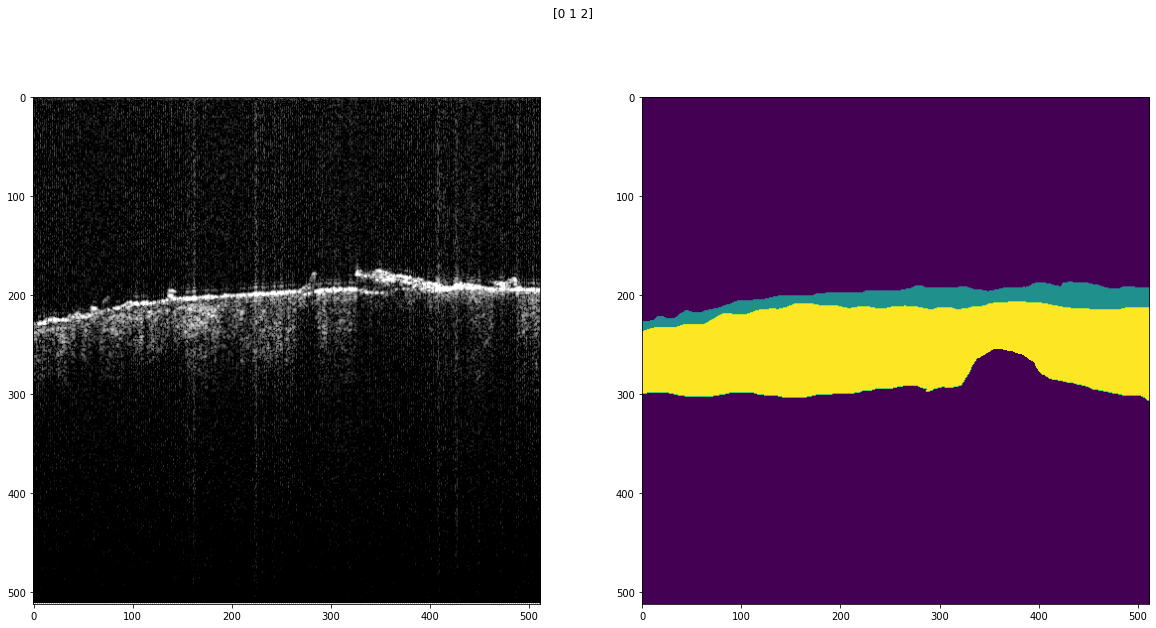

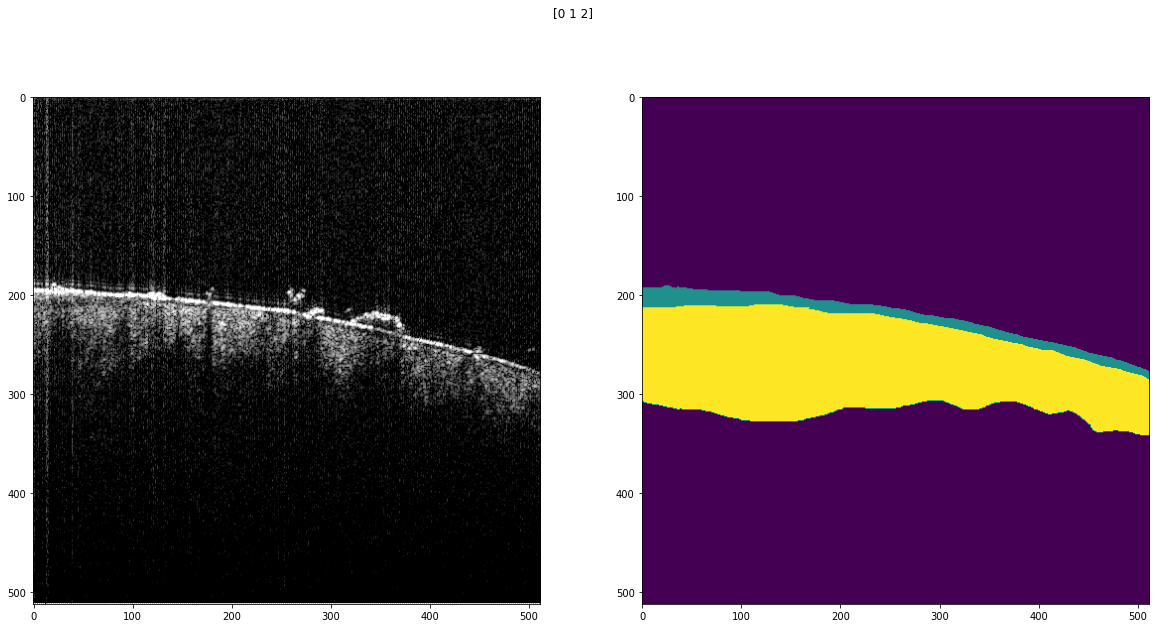

In [ ]:
for i in range(20,30):
  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
  ax1.imshow(train_images[i], cmap="gray")
  ax2.imshow(np.squeeze(train_masks[i]))
  plt.suptitle(np.unique(train_masks[i]))
  plt.show()

In [ ]:
# train_images = train_images[0:5]
# train_masks = train_masks[0:5]

In [ ]:
#Now let us define a Unet with same encoder part as out autoencoder.
#Then load weights from the original autoencoder for the first 35 layers (encoder)
input_shape = train_images[0].shape
unet_model = build_unet(input_shape)

#Print layer names for each model to verify the layers....
#First 35 layers should be the same in both models.
unet_layer_names=[]
for layer in unet_model.layers:
    unet_layer_names.append(layer.name)

autoencoder_layer_names = []
for layer in model.layers:
    autoencoder_layer_names.append(layer.name)

#Make sure the first 35 layers are the same. Remember that the exct names of the layers will be different.

#Set weights to encoder part of the U-net (first 35 layers)
for l1, l2 in zip(unet_model.layers[:35], model.layers[0:35]):
    l1.set_weights(l2.get_weights())

Model: "U_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

In [ ]:
unet_model.compile('Adam', loss = "categorical_crossentropy", metrics=["Accuracy"])
unet_model.summary()

Model: "U_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 2022)

In [ ]:
y_train.shape

(4, 512, 512, 1)

In [ ]:
history = unet_model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=100)
                    # validation_data=(X_test, y_test))
                    #class_weight=class_weights,
                    # shuffle=False)

4/4 [==============================] - 97s 23s/step - loss: 0.0000e+00 - Accuracy: 0.0030


In [ ]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy is = ", (acc * 100.0), "%")

1/1 [==============================] - 6s 6s/step - loss: 1.1785 - accuracy: 0.8900
Accuracy is =  88.99993896484375 %


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

KeyError: ignored

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy is = ", (acc * 100.0), "%")

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

# OCT Option 2


In [ ]:
SIZE_X = 512
SIZE_Y = 512 * 3

patch_size = (512, 512)
window_step = 128 # 128
n_classes=4

batch_size = 16

Load images and split into patches

In [ ]:
train_images = []

for img_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/OCT_sd/Images", "*.BMP"))):
    img = cv2.imread(img_path, 0)
    p_imgs = patchify(img, patch_size, step=window_step).reshape(-1,*patch_size)
    # print(img.shape)
    # img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(p_imgs)

In [ ]:
train_images = np.concatenate(train_images)

In [ ]:
train_images.shape

(760, 512, 512)

In [ ]:
# patches_img = patchify(train_images, (1, 128, 128), step=1)

In [ ]:
# patches_img.shape

Load masks and split into patches

In [ ]:
train_masks = []
for mask_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/OCT_sd/Mask", "*.png"))):
    mask = cv2.imread(mask_path,cv2.IMREAD_UNCHANGED)
    p_imgs = patchify(mask, patch_size, step=window_step).reshape(-1,*patch_size)
    # mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    train_masks.append(p_imgs)

In [ ]:
train_masks = np.concatenate(train_masks)

In [ ]:
train_masks.shape

(760, 512, 512)

In [ ]:
idx_lst = []
for i, single_mask in enumerate(train_masks):
  if len(np.unique(single_mask)) > 1:
    idx_lst.append(i)
len(idx_lst), train_images.shape, train_images[idx_lst].shape

(730, (760, 512, 512), (730, 512, 512))

In [ ]:
train_images, train_masks = train_images[idx_lst], train_masks[idx_lst]

In [ ]:
area = np.array([np.count_nonzero(train_masks==i) for i in [0,1,2,3]])
area/np.sum(area)

array([0.8477359 , 0.01317672, 0.0802915 , 0.05879588])

In [ ]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_reshaped_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [ ]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [ ]:
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

In [ ]:
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [ ]:
X_train.shape, y_train.shape

((525, 512, 512, 1), (525, 512, 512, 1))

In [ ]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [ ]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_masks_reshaped_encoded),y=train_masks_reshaped_encoded)

class_weights = {i:float(weight) for i, weight in enumerate(class_weights)}
#class_weights[0] = float(K.epsilon())

print("Class weights are...:", class_weights)

In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
#Now let us define a Unet with same encoder part as out autoencoder.
#Then load weights from the original autoencoder for the first 35 layers (encoder)
input_shape = train_images[0].shape
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model = get_model()
unet_model = model(input_shape)

#Print layer names for each model to verify the layers....
#First 35 layers should be the same in both models.
unet_layer_names=[]
for layer in unet_model.layers:
    unet_layer_names.append(layer.name)

autoencoder_layer_names = []
for layer in model.layers:
    autoencoder_layer_names.append(layer.name)

#Make sure the first 35 layers are the same. Remember that the exct names of the layers will be different.

#Set weights to encoder part of the U-net (first 35 layers)
for l1, l2 in zip(unet_model.layers[:35], model.layers[0:35]):
    l1.set_weights(l2.get_weights())

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train_cat,
                    batch_size = batch_size,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test_cat),
                    #class_weight=class_weights,
                    shuffle=False)

In [ ]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy is = ", (acc * 100.0), "%")

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()